### Introduction

This is a notebook that utilizes the decomposed time-series (trend, seasonality, and residual) to generate signals. 



### Decomposition

In [66]:
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import numpy as np
import talib
import matplotlib.pyplot as plt
import empyrical as ep

from statsmodels.tsa.seasonal import seasonal_decompose


In [14]:
close = pd.read_csv('../binance_futures_close_1d.csv').set_index('Open time').shift()
close.index = pd.to_datetime(close.index, utc=True)
close.head()

,BTCUSDT,ETHUSDT,BNBUSDT,BCCUSDT,NEOUSDT,LTCUSDT,QTUMUSDT,ADAUSDT,XRPUSDT,EOSUSDT,...,RENDERUSDT,TONUSDT,DOGSUSDT,EURIUSDT,SLFUSDT,POLUSDT,NEIROUSDT,TURBOUSDT,1MBABYDOGEUSDT,CATIUSDT
Open time,,,,,,,,,,,,,,,,,,,,,
2017-08-17 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-18 00:00:00+00:00,4285.08,302.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-19 00:00:00+00:00,4108.37,293.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-20 00:00:00+00:00,4139.98,290.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-21 00:00:00+00:00,4086.29,299.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
price = close['BTCUSDT'].dropna()
returns = price.pct_change().fillna(0)

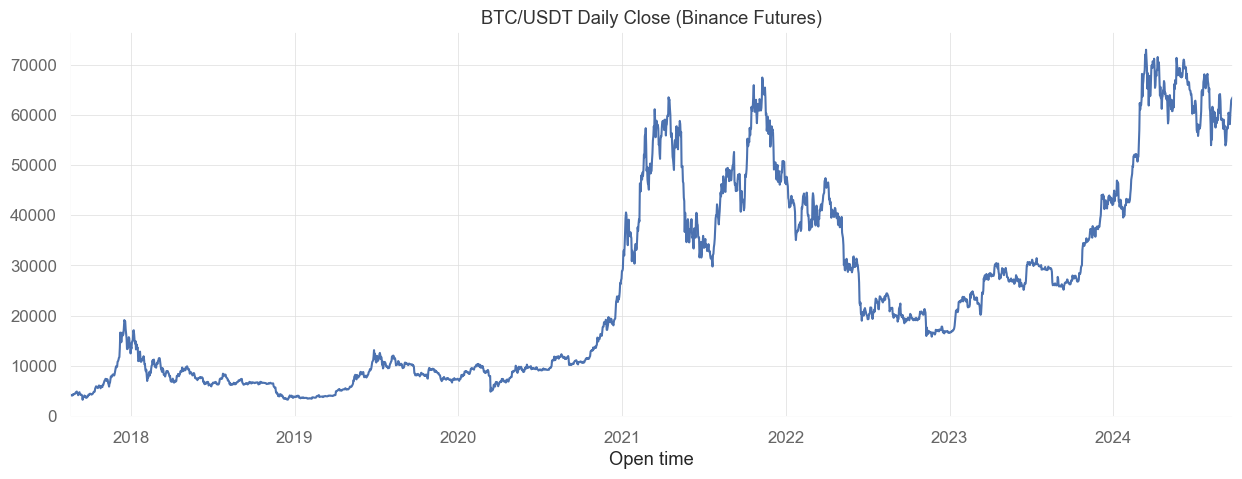

In [70]:
plt.figure(figsize=(15, 5))
price.plot()
plt.title('BTC/USDT Daily Close (Binance Futures)')
plt.show()

In [16]:
def decompose(series, model='additive', period=252):
    decomposition = seasonal_decompose(series, model=model, period=period)
    seasonality = decomposition.seasonal
    trend = decomposition.trend
    residual = decomposition.resid
    return seasonality, trend, residual

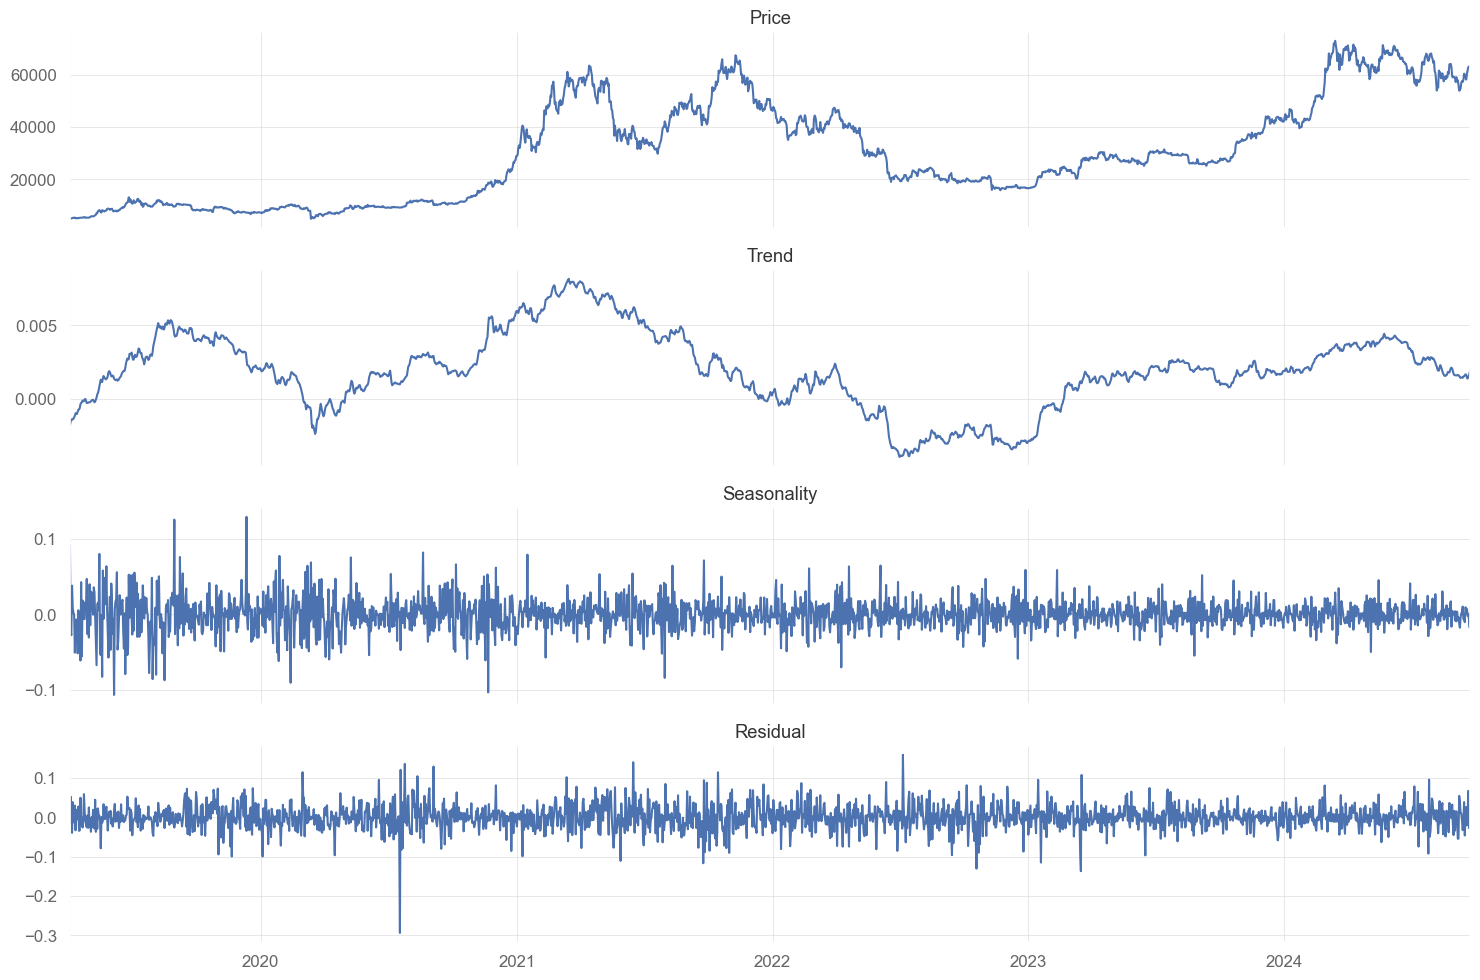

In [69]:
# Use the last 1000 days to compute a "rolling" decomposition, avoiding lookahead
out_of_sample = returns.index[-2000:]

trend = []
seasonality = []
residual = []
for day in out_of_sample:
    historical_returns = returns.loc[:day].iloc[:-1] # Exclude the last day to avoid lookahead bias
    s, t, r = decompose(historical_returns, model='additive', period=252)
    trend.append(t.ffill().iloc[-1])
    seasonality.append(s.ffill().iloc[-1])
    residual.append(r.ffill().iloc[-1])
trend = pd.Series(trend, index=out_of_sample)
seasonality = pd.Series(seasonality, index=out_of_sample)
residual = pd.Series(residual, index=out_of_sample)

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

# Plot price
price.loc[trend.index].plot(ax=ax1, title='Price')
ax1.set_xlabel('')

# Plot trend
trend.plot(ax=ax2, title='Trend')
ax2.set_xlabel('')

# Plot seasonality
seasonality.plot(ax=ax3, title='Seasonality')
ax3.set_xlabel('')

# Plot residual
residual.plot(ax=ax4, title='Residual')
ax4.set_xlabel('')

plt.tight_layout()
plt.show()



### Trend-Following Strategy

This strategy uses the trend component to generate entry and exit signals.

We go long when the trend is positive and short when the trend is negative.


C:\Users\billy\AppData\Local\Temp\ipykernel_22712\159323184.py:7: UserWarning: direction has no effect if short_entries and short_exits are set
  pf = vbt.Portfolio.from_signals(


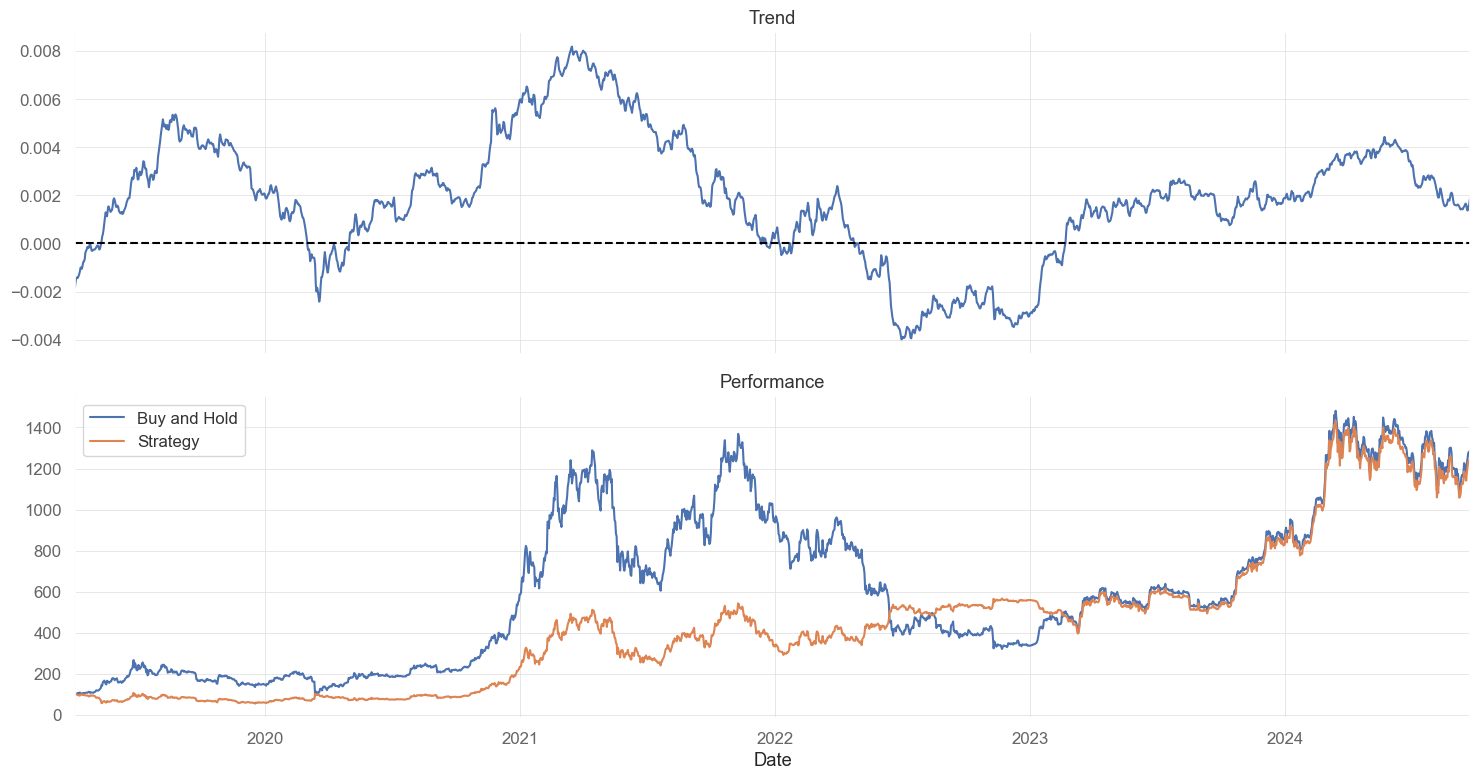

In [71]:
# Generate entry and exit signals   
long_entry = trend > 0
short_entry = trend < 0
exit_signal = trend.vbt.crossed_above(0) | trend.vbt.crossed_below(0)

# Backtest the strategy
pf = vbt.Portfolio.from_signals(
    close=price.loc[trend.index],
    entries=long_entry,
    exits=exit_signal,
    short_entries=short_entry,
    short_exits=exit_signal,
    direction='both',
    fees=0.001 # 0.1%
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Plot trend
trend.plot(ax=ax1, title='Trend')
ax1.axhline(0, color='black', linestyle='--')
ax1.set_xlabel('')

# Plot price
p = price.loc[trend.index]
p.div(p.iloc[0]).mul(100).plot(ax=ax2, title='Performance', label='Buy and Hold')
ax2.set_xlabel('')

# Plot equity curve
pf.value().plot(ax=ax2, label='Strategy')
ax2.set_xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()

### Next Steps

1. Study the seasonality component and test whether periodicity is a good signal.
2. Study the residual component and test whether mean reversion is a good signal.
3. Use ensemble methods to combine signals from the different components.
4. Make the strategies as parameter-less as possible.
5. Test with different periods for the decomposition.
